In [1]:
import sys
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel
from wordcloud import WordCloud
from collections import defaultdict
import json
import re
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

In [2]:
########### Function to get original word from stemmed word ##########
def get_common_surface_form(original_corpus, stemmer):
    counts = defaultdict(lambda : defaultdict(int))
    surface_forms = {}

    for document in original_corpus:
        for token in document:
            stemmed = stemmer.stem(token)
            counts[stemmed][token] += 1

    for stemmed, originals in counts.items():
        surface_forms[stemmed] = max(originals, 
                                     key=lambda i: originals[i])

    return surface_forms

# function to remove emoji
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

In [3]:
############## file reading and preprocessing ####################33

stemmer = PorterStemmer() # Stemmer for reducing terms to root form

stemmed_corpus = []       # For storing the stemmed tokens

original_corpus = []      # For storing the non-stemmed tokens

data_path = "Twitter5July_Data.txt"
tweets_file = open(data_path, 'r')
tweet_count = 0
tokenizer = RegexpTokenizer(r'\w+')
#Read File and save tweets into a string
for line in tweets_file:
    # strip() function removes end-of-line characters at the end
    # After removing end-of-line characters, see if the line still
    # contains any data. If it does, len() will be > 0.
    # If that's the case, let's save this Tweet Object into our LIST.
    if len(line.strip()) > 0:
        tweet = json.loads(line) # each line is a JSON object
        if 'text' in tweet and tweet['lang'] == 'en':
            text = (tweet['text']).lower()

            demoji = remove_emoji(text)
            tokens = tokenizer.tokenize(demoji) #extract tokens from the text
            
            stemmed = [stemmer.stem(token) for token in tokens] #stem the tokens

            stemmed_corpus.append(stemmed) #store stemmed document

            original_corpus.append(tokens) #store original document
            
            tweet_count += 1

            if tweet_count % 10000 == 0:
                print("Tweets Read:", tweet_count)

print("Total tweets read:", tweet_count)
dictionary = Dictionary(stemmed_corpus) # build the dictionary

counts = get_common_surface_form(original_corpus,stemmer) # get surface form

Tweets Read: 10000
Tweets Read: 20000
Tweets Read: 30000
Tweets Read: 40000
Tweets Read: 50000
Tweets Read: 60000
Total tweets read: 68513


In [4]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['rt','blacklivesmatter', 'blacklivesmatters', 'https', 'http', "blm", "co", "amp", "women", "update", "i", "was", "since", "huge", "f777jvpxpp", "on", "photography", "telegram", "for", "due", "joke", "come", "why", "last", "blacklives", "lack"]

stop_words_stemmed = [stemmer.stem(token) for token in stop_words]

stemmed_corpus_filtered = []
counter = 0
for stemmed_document in stemmed_corpus:
    toAppend = []

    for token in stemmed_document:
        if token not in stop_words_stemmed:
            toAppend.append(token)
            counter += 1
    stemmed_corpus_filtered.append(toAppend)

print("Words Filtered:", counter)
print("Stop Words Filtered")

Words Filtered: 714946
Stop Words Filtered


In [5]:
# Convert to vector corpus

vectors = [dictionary.doc2bow(text) for text in stemmed_corpus_filtered]

# Train TF-IDF model

tfidf = TfidfModel(vectors)

# Transform the corpus to tf-idf vectors

corpus_tfidf = tfidf[vectors]

# Train the LDA model

lda = LdaModel(corpus_tfidf, id2word=dictionary, num_topics=5)

# Extract 1000 terms from an arbitrarily chosen topic

print("Model Generated")


Model Generated


In [14]:
# for pair in lda.show_topic(0,topn=20):
#     print(pair)

('hungrybowti', 0.022269076)
('polic', 0.020766461)
('portlandprotest', 0.018894698)
('b', 0.015901182)
('portland', 0.013171462)
('vehicl', 0.012484081)
('peopl', 0.012175377)
('teargass', 0.0120964125)
('pull', 0.011494417)
('ga', 0.011402448)
('street', 0.011226226)
('oregon', 0.009696325)
('grenad', 0.009448022)
('stun', 0.009405504)
('pdx', 0.0072721792)
('impact', 0.0071807853)
('munit', 0.006967518)
('give', 0.006578483)
('u', 0.006412803)
('someth', 0.006302615)


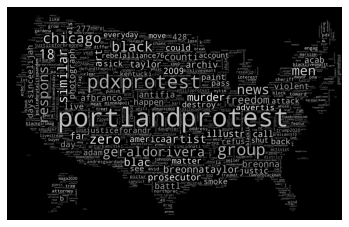

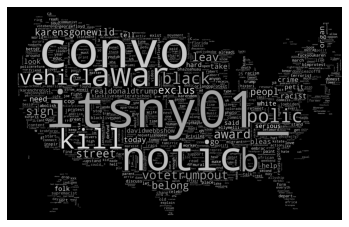

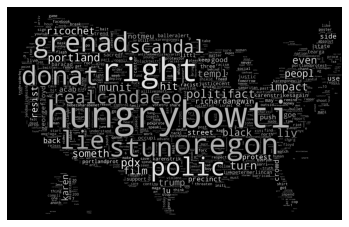

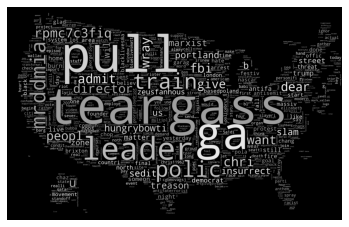

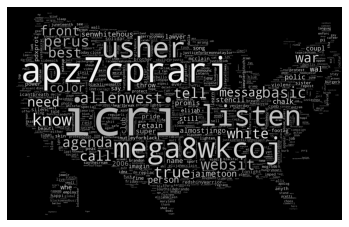

In [6]:
# To print wordcloud
# mask = np.array(Image.open("../usaMap2.jpg"))

# for i in range(5):
#     weights = [(pair[0], pair[1]) for pair in lda.show_topic(i, topn=1000)]

#     wc = WordCloud(
#         background_color="black",
#         max_words=2000,
#         width=3000,
#         height=2000,
#         mask = mask,
#         color_func=grey_color_func
#     )

#     # Generate the cloud

#     # print (dict(weights))
#     wc.generate_from_frequencies(dict(weights))

#     plt.imshow(wc)
#     plt.axis('off')
#     plt.savefig('TwitterTopicModeling'+str(i)+'.png', dpi=300)
#     plt.show()

# # print("Word Cloud Generated")

In [34]:
### to get original words ##
words = ["icri","mega8wkcoj", "usher", "apz7cprarj", "notmeu", "stun", "grenad", "munit", "someth", "ricochet", "impact", "film", "templ"]

for word in words:
    print(counts[word])

icry
mega8wkcoj
usher
apz7cprarj
notmeus
stun
grenades
munitions
something
ricocheted
impact
filming
templ


In [6]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [7]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, vectors, dictionary)
out_file = "LDAModel.html"
pyLDAvis.save_html(LDAvis_prepared,out_file)